## diagnostics

In [49]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
# from assigment_utils import *

tf.autograph.set_verbosity(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### data generation


In [50]:
#data generation
def gen_data(m, seed=1, scale=0.7):
    """ generate a data set based on a x^2 with added noise """
    c = 0
    x_train = np.linspace(0,49,m)
    np.random.seed(seed)
    y_ideal = x_train**2 + c
    y_train = y_ideal + scale * y_ideal*(np.random.sample((m,))-0.5)# noise addes
    x_ideal = x_train #for redraw when new data included in X
    return x_train, y_train, x_ideal, y_ideal

In [51]:
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print(X.shape,y.shape)
x_ideal.shape

(18,) (18,)


(18,)

#### split the data

In [52]:
# 20-40% of you data for testing
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


##### colors

In [53]:
dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'; dldarkblue =  '#0D5BDC'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]

#### plot the train test

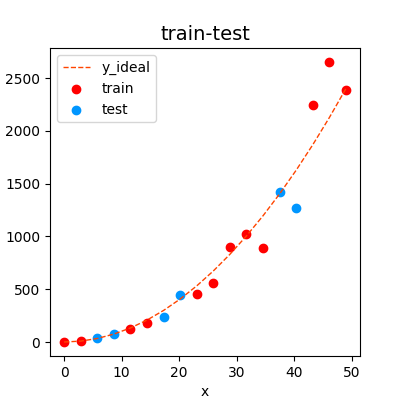

In [54]:
fig ,ax=plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal,y_ideal,"--",color="orangered",label="y_ideal", lw=1)
ax.set_title("train-test",fontsize=14)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

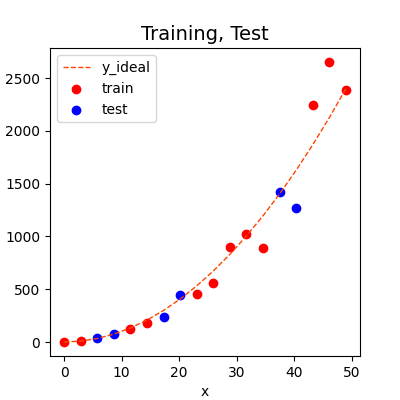

In [55]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, Y_train, color = "red",label="train")
ax.scatter(X_test, Y_test,   color = "blue",   label="test")
ax.legend(loc='upper left')
plt.show()

#### model evalutaion linear regerssion

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

In [56]:
def evaluate_err(y,yhat):
    err=0.0
    m=len(y)
    for i in range(m):
        diff=(yhat[i]-y[i])**2
        err+=diff
    err=err/(2*m)
    return err

In [77]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
evaluate_err(y_hat, y_tmp)

0.0050000000000000305

In [57]:
class lin_model:
    def __init__(self, degree, regularization = False, lambda_=0):
        if regularization:
            self.linear_model = Ridge(alpha=lambda_)
        else:
            self.linear_model = LinearRegression()
        self.poly = PolynomialFeatures(degree, include_bias=False)
        self.scaler = StandardScaler()
        
    def fit(self, X_train,y_train):
        ''' just fits the data. mapping and scaling are not repeated '''
        X_train_mapped = self.poly.fit_transform(X_train.reshape(-1,1))
        X_train_mapped_scaled = self.scaler.fit_transform(X_train_mapped)
        self.linear_model.fit(X_train_mapped_scaled, y_train )

    def predict(self, X):
        X_mapped = self.poly.transform(X.reshape(-1,1))
        X_mapped_scaled = self.scaler.transform(X_mapped)
        yhat = self.linear_model.predict(X_mapped_scaled)
        return(yhat)
    
    def mse(self, y, yhat):
        err = mean_squared_error(y,yhat)/2   #sklean doesn't have div by 2
        return (err)

###### train the model and predict 

In [58]:
degree=10
lmodel=lin_model(degree)
lmodel.fit(X_train,y_train)

yhat=lmodel.predict(X_train)
err_train=lmodel.mse(y_train,yhat)

yhat=lmodel.predict(X_test)
err_test=lmodel.mse(y_test,yhat)

In [59]:
print(f"{err_train:0.2f},{err_test:0.2f}")

58.01,171215.01


In [60]:
def plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax.set_title("Poor Performance on Test Data",fontsize = 12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax.scatter(X_train, y_train, color = "red",           label="train")
    ax.scatter(X_test, y_test,       color = dlc["dlblue"], label="test")
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    ax.plot(x, y_pred,  lw=0.5, label=f"predicted, degree={degree}")
    ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


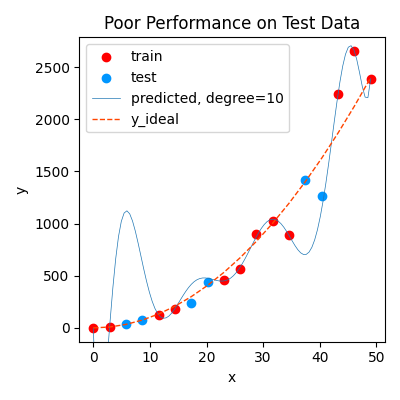

In [61]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The following plot shows why this is. The model fits the training data very well. To do so, it has created a complex function. The test data was not part of the training and the model does a poor job of predicting on this data.  
This model would be described as 1) is overfitting, 2) has high variance 3) 'generalizes' poorly.

#### Generate data

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |

In [62]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


#### plot trian test validation 

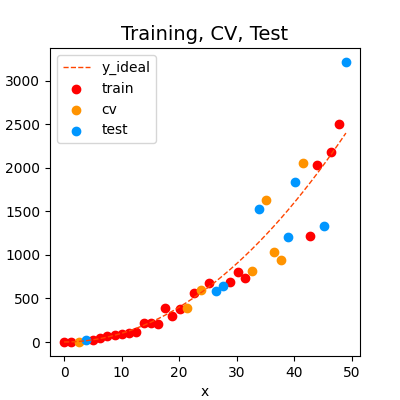

In [63]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

#### find optimal degree

In [64]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

In [65]:
def plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, err_train, err_cv, optimal_degree, max_degree):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
    ax[0].scatter(X_train, y_train, color = "red",           label="train")
    ax[0].scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,max_degree):
        ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"{i+1}")
    ax[0].legend(loc='upper left')

    ax[1].set_title("error vs degree",fontsize = 12)
    cpts = list(range(1, max_degree+1))
    ax[1].plot(cpts, err_train[0:], marker='o',label="train error", lw=2,  color = dlc["dlblue"])
    ax[1].plot(cpts, err_cv[0:],    marker='o',label="cv error",  lw=2, color = dlc["dlorange"])
    ax[1].set_ylim(*ax[1].get_ylim())
    ax[1].axvline(optimal_degree, lw=1, color = dlc["dlmagenta"])
    ax[1].annotate("optimal degree", xy=(optimal_degree,80000),xycoords='data',
                xytext=(0.3, 0.8), textcoords='axes fraction', fontsize=10,
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3", 
                                   color=dlc['dldarkred'], lw=1))
    ax[1].set_xlabel("degree")
    ax[1].set_ylabel("error")
    ax[1].legend()
    fig.suptitle("Find Optimal Degree",fontsize = 12)
    plt.tight_layout()

    plt.show()

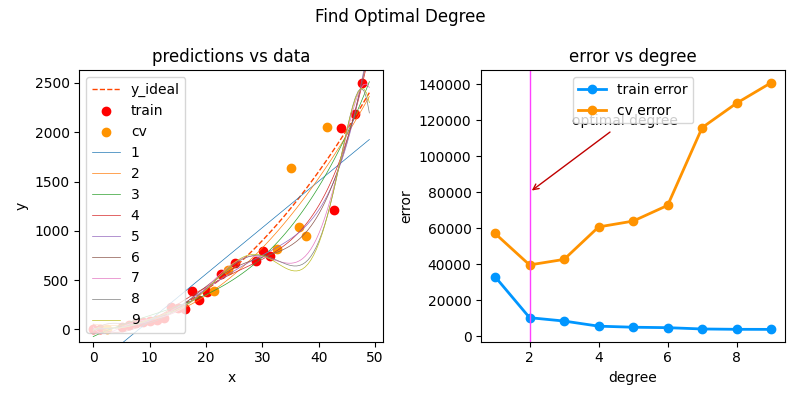

In [66]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

- the error on the trained data (blue) decreases as the model complexity increases as expected
- the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to *generalize*).     
    

#### Tunning regularization

In [67]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

In [68]:
def plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           label="train")
    ax[0].scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
#   ax[0].plot(x, y_pred[:,:],  lw=0.5, label=[f"$\lambda =${i}" for i in lambda_range])
    for i in (0,3,7,9):
        ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"$\lambda =${lambda_range[i]}")
    ax[0].legend()

    ax[1].set_title("error vs regularization",fontsize = 12)
    ax[1].plot(lambda_range, err_train[:], label="train error", color = dlc["dlblue"])
    ax[1].plot(lambda_range, err_cv[:],    label="cv error",    color = dlc["dlorange"])
    ax[1].set_xscale('log')
    ax[1].set_ylim(*ax[1].get_ylim())
    opt_x = lambda_range[optimal_reg_idx]
    ax[1].vlines(opt_x, *ax[1].get_ylim(), color = "black", lw=1)
    ax[1].annotate("optimal lambda", (opt_x,150000), xytext=(-80,10), textcoords="offset points",
                  arrowprops={'arrowstyle':'simple'})
    ax[1].set_xlabel("regularization (lambda)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning Regularization",fontsize = 12)
    ax[1].text(0.05,0.44,"High\nVariance",fontsize=12, ha='left',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].text(0.95,0.44,"High\nBias",    fontsize=12, ha='right',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_9150/237757119.py:17: SyntaxWarning: invalid escape sequence '\l'
  ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"$\lambda =${lambda_range[i]}")


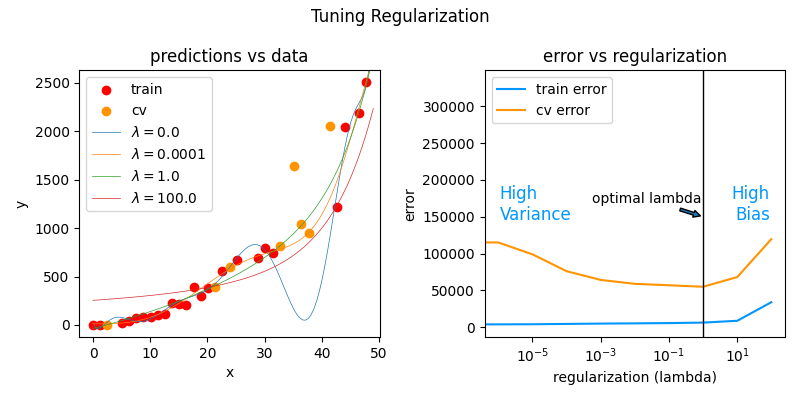

In [69]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

- > underfit(higher bais)

#### increase the training set size(m)

In [70]:
def plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree):
    
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           s=3, label="train", alpha=0.4)
    ax[0].scatter(X_cv, y_cv,       color = dlc["dlorange"], s=3, label="cv",    alpha=0.4)
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,len(m_range),3):
        ax[0].plot(x, y_pred[:,i],  lw=1, label=f"$m =${m_range[i]}")
    ax[0].legend(loc='upper left')
    ax[0].text(0.05,0.5,f"degree = {degree}", fontsize=10, ha='left',transform=ax[0].transAxes,color = dlc["dlblue"])

    ax[1].set_title("error vs number of examples",fontsize = 12)
    ax[1].plot(m_range, err_train[:], label="train error", color = dlc["dlblue"])
    ax[1].plot(m_range, err_cv[:],    label="cv error",    color = dlc["dlorange"])
    ax[1].set_xlabel("Number of Examples (m)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning number of examples",fontsize = 12)
    ax[1].text(0.05,0.5,"High\nVariance",        fontsize=12, ha='left',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].text(0.95,0.5,"Good \nGeneralization", fontsize=12, ha='right',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].legend()
    plt.tight_layout()
    plt.show()  

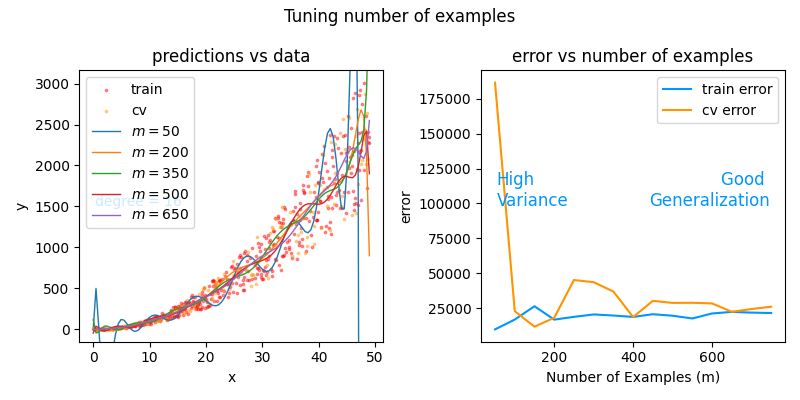

In [71]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

### evaluating the NN(learning algorithm)

##### dataset generation

In [72]:
from sklearn.datasets import make_blobs
def gen_blobs(): # Generate isotropic Gaussian blobs for clustering
    classes = 6
    m = 800
    std = 0.4
    centers = np.array([[-1, 0], [1, 0], [0, 1], [0, -1],  [-2,1],[-2,-1]])
    X, y = make_blobs(n_samples=m, centers=centers, cluster_std=std, random_state=2, n_features=2)
    return (X, y, centers, classes, std)


In [73]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs() 

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


In [74]:
import matplotlib as mpl
dkcolors = plt.cm.Paired((1,3,7,9,5,11))
ltcolors = plt.cm.Paired((0,2,6,8,4,10))
dkcolors_map = mpl.colors.ListedColormap(dkcolors)
ltcolors_map = mpl.colors.ListedColormap(ltcolors)

def recat(pt, origins):
    """ categorize a point based on distance from origin of clusters """
    nclusters = len(origins)
    min_dist = 10000
    y_new = None
    for j in range(nclusters):
        temp = origins[j] - pt.reshape(2,)
        #print(temp.shape,origins[j].shape)
        dist = np.sqrt(np.dot(temp.T, temp))
        if dist < min_dist:
            y_new = j
            min_dist = dist
    return(y_new)

def plot_cat_decision_boundary(ax, X,predict , class_labels=None, legend=False, vector=True, color='g', lw = 1):

    # create a mesh to points to plot
    pad = 0.5
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    h = max(x_max-x_min, y_max-y_min)/200
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]
    #print("points", points.shape)
    #make predictions for each point in mesh
    if vector:
        Z = predict(points)
    else:
        Z = np.zeros((len(points),))
        for i in range(len(points)):
            Z[i] = predict(points[i].reshape(1,2))
    Z = Z.reshape(xx.shape)

    #contour plot highlights boundaries between values - classes in this case
    ax.contour(xx, yy, Z, colors=color, linewidths=lw) 
    ax.axis('tight')


def plt_mc_data(ax, X, y, classes,  class_labels=None, map=plt.cm.Paired, legend=False,size=50, m='o'):
    for i in range(classes):
        idx = np.where(y == i)
        col = len(idx[0])*[i]
        label = class_labels[i] if class_labels else "c{}".format(i)
        ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
                    c=col, vmin=0, vmax=map.N, cmap=map,
                    s=size, label=label)
    if legend: ax.legend()
    ax.axis('equal')

def plt_train_eq_dist(X_train,y_train,classes, X_cv,   y_cv, centers, std):
    css = np.unique(y_train)  # classes
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plt_mc_data(ax[0], X_train,y_train,classes, map=dkcolors_map, legend=True, size=50)
    plt_mc_data(ax[0], X_cv,   y_cv,   classes, map=ltcolors_map, legend=True, m="<")
    ax[0].set_title("Training, CV Data")
    for c in css:
        circ = plt.Circle(centers[c], 2*std, color=dkcolors_map(c), clip_on=False, fill=False, lw=0.5)
        ax[0].add_patch(circ)


    #make a model for plotting routines to call
    cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
    plot_cat_decision_boundary(ax[1], X_train, cat_predict,  vector=False, color = dlc["dlmagenta"], lw=0.75)
    ax[1].set_title("ideal performance", fontsize=14)

    #add the original data to the decison boundary
    plt_mc_data(ax[1], X_train,y_train, classes, map=dkcolors_map, legend=True, size=50)
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1");
    plt.show()
    

- triangle is the cross validation 
- circle is the training

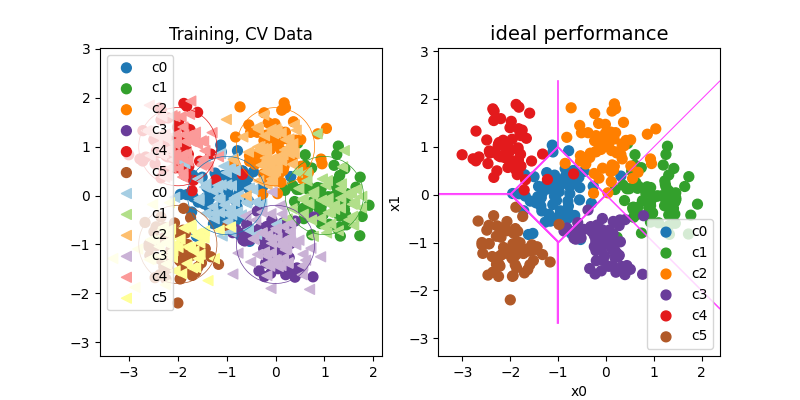

In [75]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

###  Evaluating categorical model by calculating classification error

$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

In [82]:
def evaluate_cat_err(y,yhat):
    m=len(y)
    incorrect=0
    for i in range(m):
        if yhat[i]!=y[i]:
            incorrect+=1
    caerr=incorrect/m
    return caerr

In [83]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(evaluate_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(evaluate_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )


categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250


### Model complexity

#### complex model

In [84]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(units = 120, activation = 'relu'),
        Dense(units = 40, activation = 'relu'),
        Dense(units = 6, activation = 'linear')    
    ], name="Complex"
)
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate = 0.01),
)

2024-04-05 17:26:03.793468: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-05 17:26:03.923690: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [85]:
model.fit(
    X_train, y_train,
    epochs=1000
)

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3519
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4407 
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3247 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2525 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2203 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2140 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2103 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2036 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1983 
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1973 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1938 
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1937 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1940 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1927 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [86]:
model.summary()

Model: "Complex"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (127.66 KB)

 Trainable params: 5,446 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (85.11 KB)

In [87]:
def plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle=""):
    #plot the decison boundary.
    fig,ax = plt.subplots(1,2, figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plot_cat_decision_boundary(ax[0], X_train, model_predict,  vector=True)
    ax[0].set_title("training data", fontsize=14)

    #add the original data to the decison boundary
    plt_mc_data(ax[0], X_train,y_train, classes, map=dkcolors_map, legend=True, size=75)
    ax[0].set_xlabel('x0') ; ax[0].set_ylabel("x1");

    plot_cat_decision_boundary(ax[1], X_train, model_predict,  vector=True)
    ax[1].set_title("cross-validation data", fontsize=14)
    plt_mc_data(ax[1], X_cv,y_cv, classes, 
                map=ltcolors_map, legend=True, size=100, m='<')
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1"); 
    fig.suptitle(suptitle,fontsize = 12)
    plt.show()

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


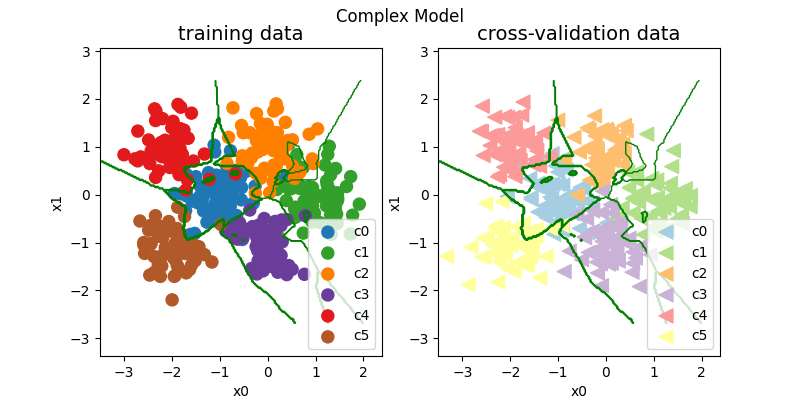

In [88]:
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [90]:
training_cerr_complex = evaluate_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = evaluate_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
categorization error, training, complex model: 0.007
categorization error, cv,       complex model: 0.106


#### simple model

In [92]:
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(units = 6, activation = 'relu'),
        Dense(units = 6, activation = 'linear')
    ], name = "Simple"
)
model_s.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate = 0.01),
)

In [93]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

model_s.fit(
    X_train,y_train,
    epochs=1000
)


Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9572
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7065 
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5233 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3491 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2019 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0732 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9561 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8522 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7639 
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6899 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6303 
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5829 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5450 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5139 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [97]:
model_s.summary()

Model: "Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 6)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182 (1.42 KB)

 Trainable params: 60 (480.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 122 (976.00 B)

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


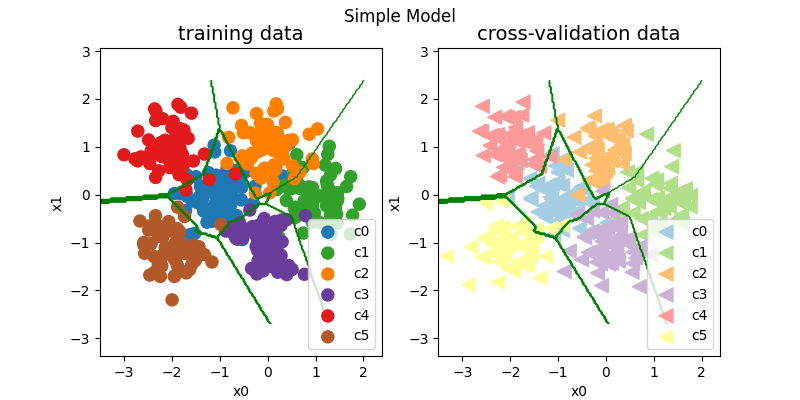

In [95]:
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

In [96]:
training_cerr_simple = evaluate_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = evaluate_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
categorization error, training, simple model, 0.060, complex model: 0.007
categorization error, cv,       simple model, 0.078, complex model: 0.106


- > Our simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

### Regularization

In [98]:
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(units = 120, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.1)),
        Dense(units = 40, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.1)),
        Dense(units = 6, activation = 'linear'),
    ], name= None
)
model_r.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate = 0.01)
)

In [99]:
model_r.fit(
    X_train, y_train,
    epochs=1000
)

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.7140
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7089 
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3143 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0812 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9953 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9481 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8951 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8487 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8121 
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7855 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7647 
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7458 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7292 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7163 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [100]:
model_r.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (127.66 KB)

 Trainable params: 5,446 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (85.11 KB)

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


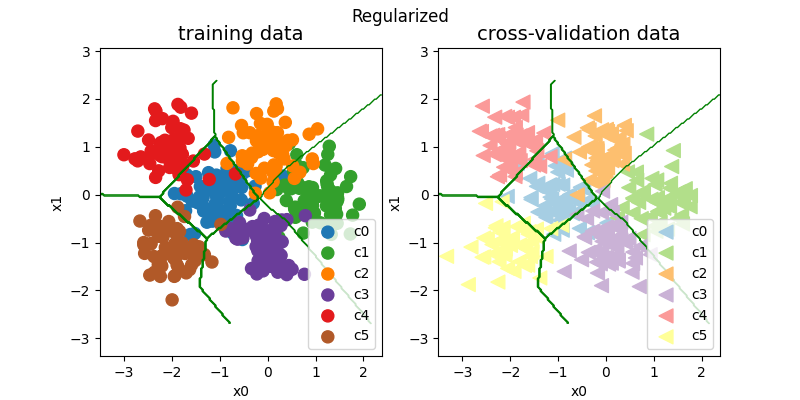

In [103]:
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

In [104]:
training_cerr_reg = evaluate_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = evaluate_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = evaluate_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
categorization error, training, regularized: 0.083, simple model, 0.060, complex model: 0.007
categorization error, cv,       regularized: 0.075, simple model, 0.078, complex model: 0.106


The simple model is a bit better in the training set than the regularized model but it worse in the cross validation set.

#### Iterate to find optimal regularization value

In [105]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3412
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4262 
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3306 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2722 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2184 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2134 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2148 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2099 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2001 
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1922 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1939 
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1915 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1912 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1879 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [110]:
def plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv):
    err_train = np.zeros(len(lambdas))
    err_cv = np.zeros(len(lambdas))
    for i in range(len(models)):
        err_train[i] = evaluate_cat_err(y_train,np.argmax( models[i](X_train), axis=1))
        err_cv[i] = evaluate_cat_err(y_cv, np.argmax( models[i](X_cv), axis=1))

    fig, ax = plt.subplots(1,1,figsize=(6,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    ax.set_title("error vs regularization",fontsize = 12)
    ax.plot(lambdas, err_train, marker='o', label="train error", color = dlc["dlblue"])
    ax.plot(lambdas, err_cv,    marker='o', label="cv error",    color = dlc["dlorange"])
    ax.set_xscale('log')
    ax.set_ylim(*ax.get_ylim())
    ax.set_xlabel("Regularization (lambda)",fontsize = 14)
    ax.set_ylabel("Error",fontsize = 14)
    ax.legend()
    fig.suptitle("Tuning Regularization",fontsize = 14)
    ax.text(0.05,0.14,"Training Error\nlower than CV",fontsize=12, ha='left',transform=ax.transAxes,color = dlc["dlblue"])
    ax.text(0.95,0.14,"Similar\nTraining, CV",    fontsize=12, ha='right',transform=ax.transAxes,color = dlc["dlblue"])
    plt.show()
 

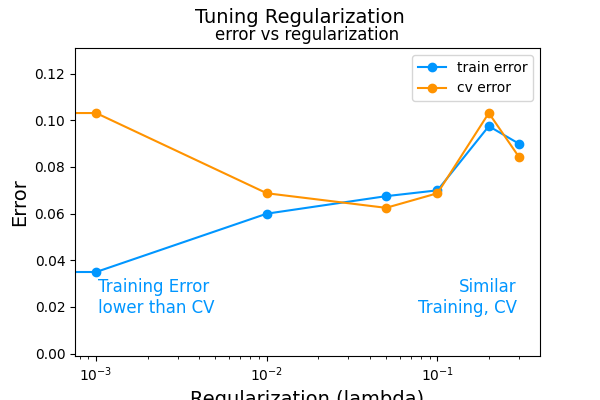

In [111]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)


As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

### Test

In [113]:
def plt_compare(X,y, classes, simple, regularized, centers):
    plt.close("all")
    fig,ax = plt.subplots(1,3, figsize=(8,3))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

  #plt simple   
    plot_cat_decision_boundary(ax[0], X, simple,  vector=True)
    ax[0].set_title("Simple Model", fontsize=14)
    plt_mc_data(ax[0], X,y, classes, map=dkcolors_map, legend=True, size=75)
    ax[0].set_xlabel('x0') ; ax[0].set_ylabel("x1");

  #plt regularized   
    plot_cat_decision_boundary(ax[1], X, regularized,  vector=True)
    ax[1].set_title("Regularized Model", fontsize=14)
    plt_mc_data(ax[1], X,y, classes, map=dkcolors_map, legend=True, size=75)
    ax[1].set_xlabel('x0') ; ax[0].set_ylabel("x1");

  #plt ideal
    cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
    plot_cat_decision_boundary(ax[2], X, cat_predict,  vector=False)
    ax[2].set_title("Ideal Model", fontsize=14)
    plt_mc_data(ax[2], X,y, classes, map=dkcolors_map, legend=True, size=75)
    ax[2].set_xlabel('x0') ; ax[0].set_ylabel("x1");

    err_s = evaluate_cat_err(y, simple(X))
    err_r = evaluate_cat_err(y, regularized(X))
    ax[0].text(-2.75,3,f"err_test={err_s:0.2f}", fontsize=12)
    ax[1].text(-2.75,3,f"err_test={err_r:0.2f}", fontsize=12)
    m = len(X)
    y_eq  = np.zeros(m)
    for i in range(m):
        y_eq[i] = recat(X[i], centers)
    err_eq = evaluate_cat_err(y, y_eq)
    ax[2].text(-2.75,3,f"err_test={err_eq:0.2f}", fontsize=12)
    plt.show()

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


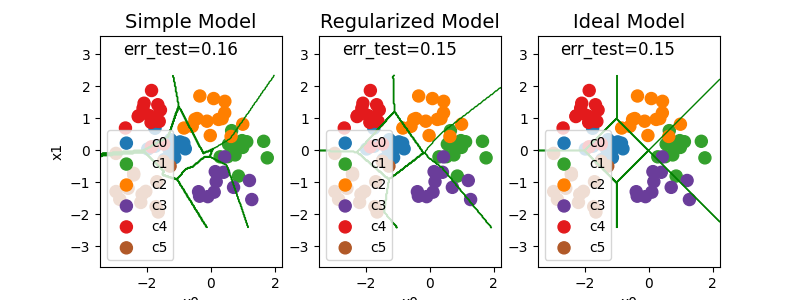

In [114]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)